In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import optuna

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import Lasso, LogisticRegression

import catboost
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

import os
import sys
import datetime

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)


In [3]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [4]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [5]:
# train = pd.concat([train, orig]).reset_index(drop=True)
# def fe(df):
#     df['Mean_DMSNR_Skewness_Ratio'] = df['Mean_DMSNR_Curve'] / df['Skewness_DMSNR_Curve']
#     df['SD_Integrated_Skewness_Ratio'] = df['SD'] / df['Skewness']
#     df['EK_Integrated_SD_Ratio'] = df['EK'] / df['SD']
#     return df

# train = fe(train)
# test = fe(test)

# def f_eng(df):
#     df['Skewness_Power3'] = df['Skewness'].apply(lambda x: x**3)
#     df['EK_Power3'] = df['EK'].apply(lambda x: x**3)
#     df['cos(EK)'] = df['EK'].apply(lambda x: np.cos(x))
#     df['SD_x_EK'] = df['SD'] * df['EK']
#     df['cos(EK)_x_SD'] = df['cos(EK)'] * df['SD']
#     df['SD_DMSNR_Curve_x_Skewness_Power3'] = df['SD_DMSNR_Curve'] * df['Skewness_Power3']
#     df['EK_divide_EK_Power3'] = df['EK'] / df['EK_Power3']
#     df['EK_multiply_SD'] = df['EK'] * df['SD']
#     df['EK_divide_SD'] = df['EK'] / df['SD']
#     df['EK_multiply_SD_DMSNR_Curve'] = df['EK'] * df['SD_DMSNR_Curve']
#     df['SD_DMSNR_Curve_divide_SD'] = df['SD_DMSNR_Curve'] / df['SD']
#     df['SD_multiply_EK_Power3'] = df['SD'] * df['EK_Power3']
#     df['SD_DMSNR_Curve_multiply_SD'] = df['SD_DMSNR_Curve'] * df['SD']
#     df['EK_Power3_multiply_SD_DMSNR_Curve'] = df['EK_Power3'] * df['SD_DMSNR_Curve']
#     df['cos(EK)_multiply_SD_DMSNR_Curve'] = df['cos(EK)'] * df['SD_DMSNR_Curve']
#     return df

def f_eng(df):
    

train = f_eng(train)
test = f_eng(test)
orig = f_eng(orig)

In [6]:
scaler = RobustScaler()

y = train['Class']
X = train.drop(['Class'], axis=1)

In [7]:
PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED) 

# gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbr_params = {
            'iterations':9999,
            'depth': 3,
            'learning_rate': 0.15687380686250746,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
            'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'SymmetricTree',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            
            
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostClassifier(**cbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose=150,
         )
    modelsCB.append(model)
    predsCB.append(model.predict_proba(test)[:, 1])

0:	learn: 0.3708325	test: 0.3705587	best: 0.3705587 (0)	total: 57ms	remaining: 9m 30s
150:	learn: 0.0301481	test: 0.0302435	best: 0.0302190 (146)	total: 788ms	remaining: 51.4s
300:	learn: 0.0282430	test: 0.0296233	best: 0.0296226 (299)	total: 1.52s	remaining: 48.9s
450:	learn: 0.0268376	test: 0.0295071	best: 0.0294909 (439)	total: 2.19s	remaining: 46.4s
600:	learn: 0.0257136	test: 0.0294509	best: 0.0293853 (557)	total: 2.85s	remaining: 44.6s
750:	learn: 0.0246609	test: 0.0293351	best: 0.0293027 (719)	total: 3.53s	remaining: 43.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.02930266417
bestIteration = 719

Shrink model to first 720 iterations.
0:	learn: 0.3753321	test: 0.3751958	best: 0.3751958 (0)	total: 4.43ms	remaining: 44.3s
150:	learn: 0.0289967	test: 0.0321620	best: 0.0321620 (150)	total: 640ms	remaining: 41.8s
300:	learn: 0.0271122	test: 0.0318217	best: 0.0317945 (294)	total: 1.26s	remaining: 40.6s
450:	learn: 0.0257152	test: 0.0316605	best: 0.0316517 (44

In [8]:
def get_fi(model):
    feature_importance =  [model[x].feature_importances_ for x in range(CFG.NFOLDS*CFG.REPEATS)]
    feature_importance = np.average(feature_importance,axis=0)
    feature_df = pd.DataFrame(feature_importance, index=X.columns)

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
                color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
                linewidth=0.5, edgecolor="black", ax=ax)
    ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
    ax.set(xlabel=None)

    for s in ['right', 'top']:
        ax.spines[s].set_visible(False)

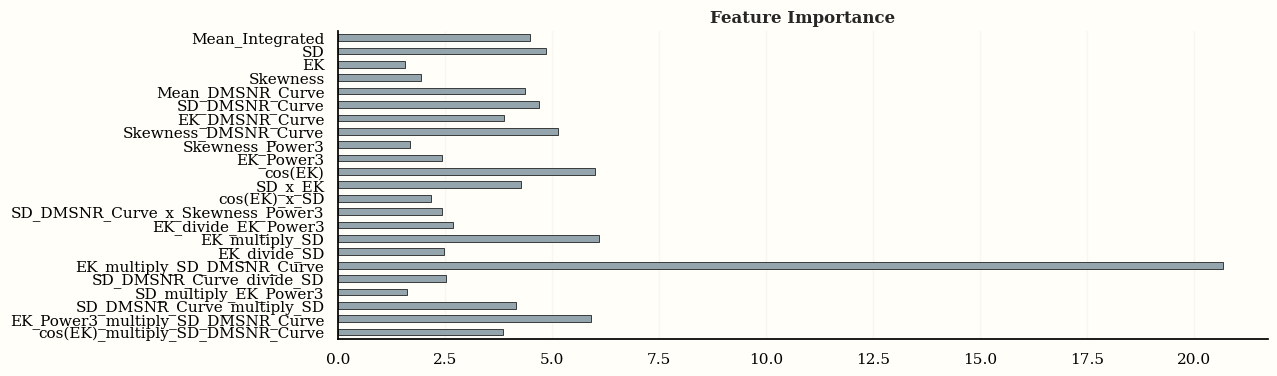

In [9]:
get_fi(modelsCB)

In [10]:
from xgboost import XGBClassifier, XGBRegressor

modelsXB = []
predsXB = []

PATIENCE = 50

xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.05333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': CFG.SEED}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict_proba(test)[:, 1])

[0]	validation_0-logloss:0.64292
[100]	validation_0-logloss:0.03148
[200]	validation_0-logloss:0.02946
[300]	validation_0-logloss:0.02903
[400]	validation_0-logloss:0.02882
[500]	validation_0-logloss:0.02888
[510]	validation_0-logloss:0.02891
[0]	validation_0-logloss:0.64283
[100]	validation_0-logloss:0.03322
[200]	validation_0-logloss:0.03175
[300]	validation_0-logloss:0.03169
[330]	validation_0-logloss:0.03174
[0]	validation_0-logloss:0.64293
[100]	validation_0-logloss:0.03464
[200]	validation_0-logloss:0.03299
[267]	validation_0-logloss:0.03293
[0]	validation_0-logloss:0.64283
[100]	validation_0-logloss:0.03188
[200]	validation_0-logloss:0.03021
[300]	validation_0-logloss:0.02994
[330]	validation_0-logloss:0.02994
[0]	validation_0-logloss:0.64289
[100]	validation_0-logloss:0.03342
[200]	validation_0-logloss:0.03228
[266]	validation_0-logloss:0.03223
[0]	validation_0-logloss:0.64294
[100]	validation_0-logloss:0.03400
[200]	validation_0-logloss:0.03243
[282]	validation_0-logloss:0.032

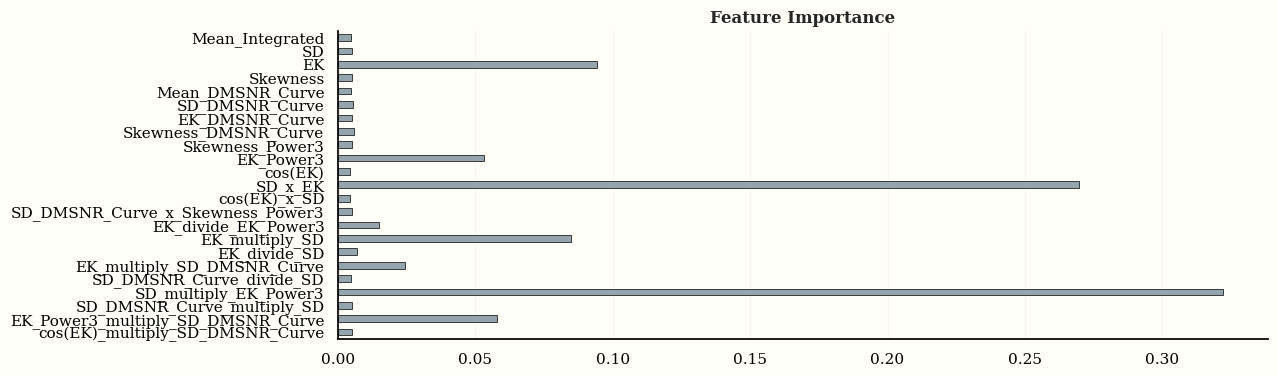

In [11]:
get_fi(modelsXB)

In [12]:
modelsLB = []
predsLB = []

PATIENCE = 50

# gpu_params = {'device' : "gpu"}
lgbr_params = {
            'n_estimators': 9999,
            'max_depth': 5,
            'learning_rate': 0.00693702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203,
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
           
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMClassifier(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_metric = 'logloss',
          early_stopping_rounds = PATIENCE,
          verbose = 150
         )
    modelsLB.append(model)
    predsLB.append(model.predict_proba(test)[:, 1])

[150]	valid_0's binary_logloss: 0.0859485
[300]	valid_0's binary_logloss: 0.0466916
[450]	valid_0's binary_logloss: 0.0349892
[600]	valid_0's binary_logloss: 0.0313985
[750]	valid_0's binary_logloss: 0.0303352
[900]	valid_0's binary_logloss: 0.0299471
[1050]	valid_0's binary_logloss: 0.0297236
[1200]	valid_0's binary_logloss: 0.0295698
[1350]	valid_0's binary_logloss: 0.0294573
[1500]	valid_0's binary_logloss: 0.0293996
[1650]	valid_0's binary_logloss: 0.0293594
[150]	valid_0's binary_logloss: 0.087062
[300]	valid_0's binary_logloss: 0.0482136
[450]	valid_0's binary_logloss: 0.0368172
[600]	valid_0's binary_logloss: 0.033419
[750]	valid_0's binary_logloss: 0.0324647
[900]	valid_0's binary_logloss: 0.0322756
[1050]	valid_0's binary_logloss: 0.0322022
[1200]	valid_0's binary_logloss: 0.032169
[1350]	valid_0's binary_logloss: 0.03215
[150]	valid_0's binary_logloss: 0.0870472
[300]	valid_0's binary_logloss: 0.0486781
[450]	valid_0's binary_logloss: 0.0376747
[600]	valid_0's binary_logloss:

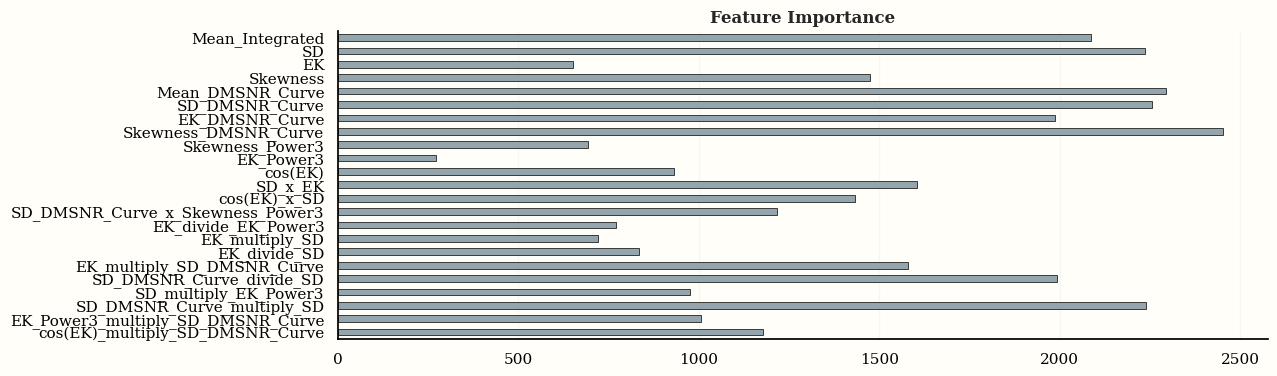

In [13]:
get_fi(modelsLB)

In [58]:
modelsLR = []
predsLR = []
predsLR2 = []

params = {
        'max_iter': 10000,
        'C': 0.1,
        'tol': 0.001029268232213037,
        'n_jobs': -1,
        'random_state': CFG.SEED,
        'verbose': 100
    }

for train_index, test_index in k_fold.split(XLR, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(**params)
    model.fit(X=X_train, y=y_train)
    ypred = model.predict_proba(X_valid)[:, 1]
    score = log_loss(y_valid, ypred)
    print(f'Score: {score}')
    
    modelsLR.append(model)
    predsLR.append(model.predict_proba(testLR)[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
Score: 0.056492758532931266
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished
Score: 0.05627772303481176
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.2s finished
Score: 0.05401251493535325
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
Score: 0.05642864341826786
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4

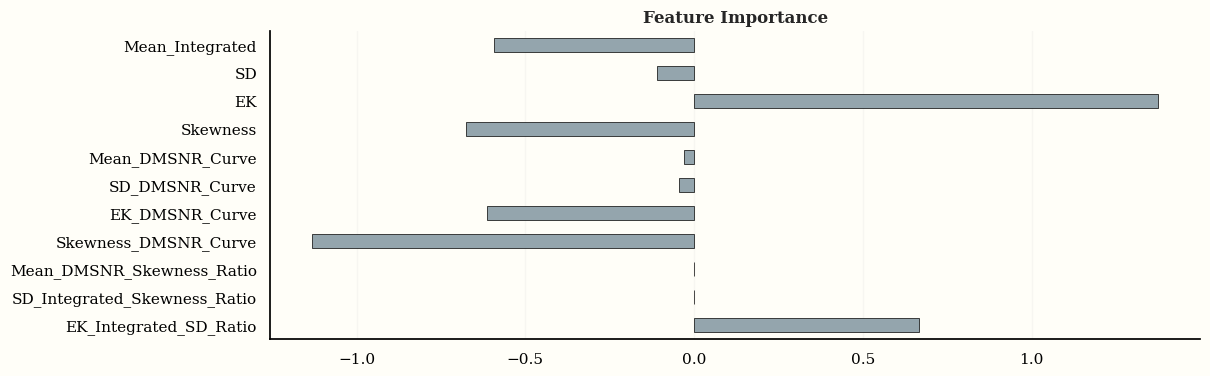

In [38]:
feature_importance =  np.array([modelsLR[x].coef_ for x in range(CFG.NFOLDS*CFG.REPEATS)])
feature_importance = feature_importance.reshape((CFG.NFOLDS*CFG.REPEATS, XLR.shape[1]))
feature_importance = np.average(feature_importance,axis=0)
feature_df = pd.DataFrame(feature_importance, index=X.columns)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
            color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax)
ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
ax.set(xlabel=None)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

In [14]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0.5, 1)
    c = trial.suggest_float('c', 0.5, 1)
    #e = trial.suggest_float('e', 0, 0.1)
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resLB = np.average(np.array(preds_eval),axis=0)
    
    # preds_eval = []
    # for model in modelsLR:
    #     preds_eval.append(model.predict_proba(XLR)[:, 1])
    # resLR = np.average(np.array(preds_eval),axis=0)
    
    res1 =  (resCB * a + resXB * b + resLB * c)/(a + b + c)
    res = log_loss(y, res1)
    return res

study = optuna.create_study(direction= 'minimize')

[I 2023-03-15 21:36:11,884] A new study created in memory with name: no-name-286b7819-e36f-4147-bff9-64c705d70ffd


In [15]:
study.optimize(coef_objective, n_trials=100)
coef_dict = study.best_params
coef_dict

[I 2023-03-15 21:36:26,219] Trial 0 finished with value: 0.024047100506037207 and parameters: {'a': 0.18685366466640396, 'b': 0.5917005300595647, 'c': 0.7316723048078267}. Best is trial 0 with value: 0.024047100506037207.
[I 2023-03-15 21:36:39,972] Trial 1 finished with value: 0.024187310436322527 and parameters: {'a': 0.15579679638069754, 'b': 0.5988449648554289, 'c': 0.5544237042534901}. Best is trial 0 with value: 0.024047100506037207.
[I 2023-03-15 21:36:54,033] Trial 2 finished with value: 0.024252740158180717 and parameters: {'a': 0.19416275932082216, 'b': 0.8163810776959717, 'c': 0.6655786902434186}. Best is trial 0 with value: 0.024047100506037207.
[I 2023-03-15 21:37:07,685] Trial 3 finished with value: 0.024173853119950215 and parameters: {'a': 0.6501767417191494, 'b': 0.5200447341091528, 'c': 0.7315861469088372}. Best is trial 0 with value: 0.024047100506037207.
[I 2023-03-15 21:37:20,634] Trial 4 finished with value: 0.02422609557511697 and parameters: {'a': 0.935414503137

{'a': 0.00031018344320955446, 'b': 0.504114571912938, 'c': 0.9865108257616197}

In [15]:
coef_dict

{'a': 0.0013682907407197736, 'b': 0.501503861612639, 'c': 0.9764370513390045}

In [16]:
predCB = np.average(np.array(predsCB),axis=0)
predXB = np.average(np.array(predsXB),axis=0)
predLB = np.average(np.array(predsLB),axis=0)

pred = (predCB * coef_dict['a'] + predXB * coef_dict['b'] + predLB * coef_dict['c']) / (coef_dict['a'] + coef_dict['b'] + coef_dict['c'])

In [18]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = pred
submission.to_csv(
    os.path.join(CFG.BASE_PATH, 'submissions', f'CT-XG-LGB-_new-features_{datetime.datetime.strftime(datetime.datetime.now(), "%m-%d_%H:%M")}.csv'),
    index=False)

In [19]:
submission['Class'].values

array([1.22908827e-04, 1.26806905e-03, 1.48233323e-04, ...,
       1.83770664e-04, 7.21910139e-02, 9.81661188e-01])

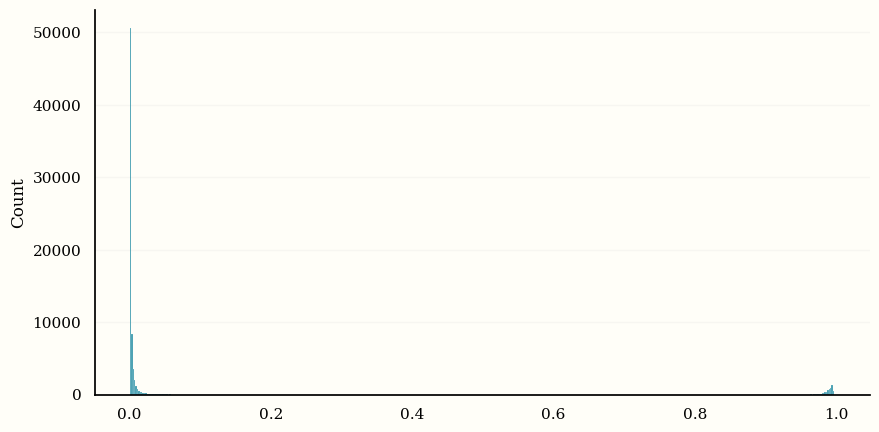

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(pred, bins=500, color=palette[1], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True)